# Learning the Viscous Burgers' Equation
$$u_t=uu_x+0.1u_{xx}$$


In [1]:
import sys; sys.path.append('../')
import scipy.io as sio
import numpy as np
import time as _time
import matplotlib.pylab as plt
from typing import List
from mpl_toolkits.mplot3d import Axes3D

import scikit_tt as scikit 
import scikit_tt.data_driven.transform as tdt
import scikit_tt.data_driven as reg
from scikit_tt.data_driven.transform import Function # GitHub: https://github.com/PGelss/ scikit_tt.


import auxiliary as aux

In [2]:
# Load data
data = sio.loadmat('Burgers.mat')
N = data['N'][0][0]
h = data['h'][0][0]
x = data['x']
t = data['t']
u = data['u']
dt = data['dt']
alpha = data['alpha'][0][0]
ut = data['udot']
u0 = data['u0']
# Define mesh
tmesh = np.outer(t,np.ones(x.shape[1]))
xmesh = np.outer(np.ones(t.shape[1]),x)

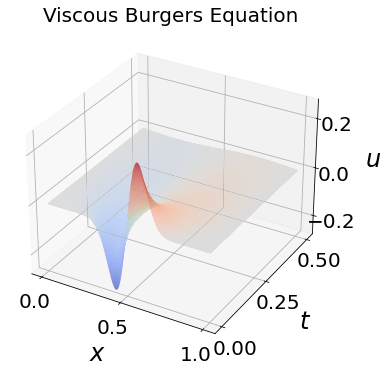

In [3]:
fig = plt.figure(figsize=(6.5,6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xmesh, tmesh, u, cmap=plt.cm.coolwarm,
                       rstride=1, cstride=1, linewidth=0)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
ax.set_xlabel('$x$', fontsize = 24, labelpad = 15.0)
ax.set_ylabel('$t$', fontsize = 24, labelpad = 15.0)
ax.set_zlabel('$u$', fontsize = 24, labelpad = 15.0)
plt.title('Viscous Burgers Equation', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='z', labelsize=20)
plt.show()

# Compute partial derivtives of $u$

In [4]:
ux = aux.dudx(u, h)
uxx = aux.dudx(ux, h)
uxxx = aux.dudx(uxx, h)
ut = aux.dudt(u, dt)

# Collect candidate functions for the dictionary matrix

In [5]:
T = 10 # subset time
M1 = 0 # subset space
M2 = 70
U = np.array([u[:T,M1:M2].reshape(T*(M2-M1)),
              ux[:T,M1:M2].reshape(T*(M2-M1)),
             uxx[:T,M1:M2].reshape(T*(M2-M1))])
v = np.array([ut[:T,M1:M2].reshape(T*(M2-M1))])

# Construct the exact solution $\Xi^*$

Construction of the exact coefficient tensor for the application of our method to the Burgers' equation using the basic set $\mathcal{P}$ and $\mathcal{U}$.

In [6]:
P = [lambda t: 1, lambda t: t]
p = len(P)

core_type_1 = np.zeros([1, p, 1, 1])
core_type_1[0, 0, 0, 0] = 1

core_type_2 = np.zeros([1, p, 1, 1]) 
core_type_2[0, 1, 0, 0] = 1

core_type_4 = np.zeros([1, 1, 1, 1])
core_type_4[0, 0, 0, 0] = 1

cores = [core_type_2]
cores.append(core_type_2)
cores.append(core_type_1)
cores.append(core_type_4)
coefficient_tensor = scikit.TT(cores) # u ux

cores = [core_type_1]
cores.append(core_type_1)
cores.append(alpha*core_type_2)
cores.append(core_type_4)
coefficient_tensor += scikit.TT(cores) # uxx

xi_exact = coefficient_tensor

In [7]:
xi_exact.full().flatten()

array([0. , 0.1, 0. , 0. , 0. , 0. , 1. , 0. ])

# Solve for $\Xi$

In [8]:
start_time = scikit.utils.progress('Running MANDy (eps=1e-5)', 0)
with scikit.utils.timer() as time:
    xi = aux.mandy_cm(U, v, P, threshold=1e-5)

Running MANDy (eps=1e-5)                       
                                         0.0000%
CPU time: 0.0000s 

In [9]:
xi.full().flatten()

array([-1.40540937e-05,  9.99856476e-02,  1.40730067e-05,  1.00929945e-05,
       -4.98468527e-03, -1.38679130e-05,  9.95854636e-01,  4.81873843e-06])

In [10]:
# Relative error
rel_errors= (xi - xi_exact).norm() / xi_exact.norm()
scikit.utils.progress('Running MANDy (eps=1e-5)', 100, cpu_time=_time.time() - start_time)
print("Relative error to identify Burger's equation:", rel_errors)

Running MANDy (eps=1e-5)                       
                                           100%
CPU time: 0.9898s 

Relative error to identify Burger's equation: 0.006451037908805789


In [11]:
# Candidates
candidates = []
for u in ['', 'u ']:
    for ux in ['', 'ux ']:
        for uxx in ['', 'uxx ']:
            candidates.append(u+ux+uxx)
candidates[0]='1'
candidates

['1', 'uxx ', 'ux ', 'ux uxx ', 'u ', 'u uxx ', 'u ux ', 'u ux uxx ']